## Introduction
This is a modified kernel with starter code demonstrating how to read in the data, preprocess the data, and begin exploring. Click the blue "Edit Notebook" or "Fork Notebook" button at the top of this kernel to begin editing.

## Exploratory Analysis
To begin this exploratory analysis, first use `matplotlib` to import libraries and define functions for plotting the data.

In [40]:
import itertools
import re

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.decomposition import PCA


There is 1 csv file in the current version of the dataset:


The next hidden code cells define functions for plotting data. Click on the "Code" button in the published kernel to reveal the hidden code.

In [3]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [4]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [5]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


Now you're ready to read in the data and use the plotting functions to visualize the data.

### Let's check 1st file: ../input/steam.csv

In [7]:
raw1 = pd.read_csv('steam.csv', delimiter=',')
nRow, nCol = raw1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 27075 rows and 18 columns


Let's take a quick look at what the raw data looks like:

In [8]:
raw1.head(5)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


Now let's do a bit of feature engineering, and transform some columns into more useful ones.

In [16]:
def remove_non_english(df):
    # El porcentaje de aplicaciones que no son en ingles son de 2~%, preferible botarlas
    df = df[df['english'] == 1].copy()
    
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]
    
    df = df.drop('english', axis=1)
    
    return df


def calc_rating(row):

    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg

    average = pos / total_reviews

    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100


def get_unique(series):
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))


def process_cat_gen_tag(df):
    cat_cols = get_unique(df['categories'])
    
    # remove comments to use all categories
    cat_cols = [
        'Multi-player',
        'Single-player'
    ]
    
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    gen_cols = get_unique(df['genres'])
    
    # remove comments to use all genres. Currently uses main ones as per steam store home page
    gen_cols = [
        'Action',
        'Adventure',
        'Casual',
        'Indie',
        'Massively Multiplayer',
        'RPG',
        'Racing',
        'Simulation',
        'Sports',
        'Strategy'
    ]
    
    gen_col_names = []
    
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
    
    # remove "non-games" based on genre
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0]
        
    tag_cols = get_unique(df['steamspy_tags'])
    # df['top_tag'] = df['tags'].apply(lambda x: x.split(';')[0] if ';' in x else x)
    
    # display(cat_cols, gen_cols, tag_cols)
    df = df.drop(['categories', 'genres', 'steamspy_tags'], axis=1)
    
    return df


def process_year(df):
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    return df

    
def process_revenue(df):
    df['est_revenue'] = df['owners'] * df['price']
    return df


def process_price(df):
    cut_points = [-1, 0, 4, 10, 30, 50, 1000]
    label_names = ['free', 'very cheap', 'cheap', 'moderate', 'expensive', 'very expensive']
    
    df['price_categories'] = pd.cut(df['price'], cut_points, labels=label_names)
    
    return df


def pre_process(df):
    # english only
    df = remove_non_english(df)
    
    # windows only
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()
    
    df['owners'] = df['owners'].str.split('-').apply(lambda x: (int(x[0]) + int(x[1])) / 2).astype(int)
    # df['owners'] = df['owners'].str.replace('[+,]', '').astype(int)
    
    # calculate ratings
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['ratings_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['weighted_rating'] = df.apply(calc_rating, axis=1)
    # df = df.drop(['positive', 'negative'], axis=1)
    
    df = df.rename(columns={'average_forever': 'average_playtime', 'median_forever': 'median_playtime'})
    
    df = process_year(df)
    df = process_revenue(df)
    df = process_price(df)
    df = process_cat_gen_tag(df)
    
    return df

df1 = pre_process(raw1)
df1.dataframeName = 'steam'

nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns after preprocessing')


There are 25951 rows and 31 columns after preprocessing


,appid,name,release_date,developer,publisher,required_age,achievements,positive_ratings,negative_ratings,average_playtime,...,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,10,Counter-Strike,2000-11-01,Valve,Valve,0,0,124534,3339,17612,...,1,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,0,0,3318,633,277,...,1,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,Valve,Valve,0,0,3416,398,187,...,1,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,0,0,1273,267,258,...,1,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,0,0,5250,288,624,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,SHEN JIAWEI,SHEN JIAWEI,0,7,3,0,0,...,0,1,1,1,0,0,0,0,0,0
27071,1065570,Cyber Gun,2019-04-23,Semyon Maximov,BekkerDev Studio,0,0,8,1,0,...,1,1,0,1,0,0,0,0,0,0
27072,1065650,Super Star Blast,2019-04-24,EntwicklerX,EntwicklerX,0,24,0,1,0,...,1,0,1,1,0,0,0,0,0,0
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,Yustas Game Studio,Alawar Entertainment,0,0,2,0,0,...,0,1,1,1,0,0,0,0,0,0


Let's have a look at the breakdown of genres, and how the average amount of owners per game compares to the proportion of games in each genre. It's important to remember that a single game can belong to multiple genres.

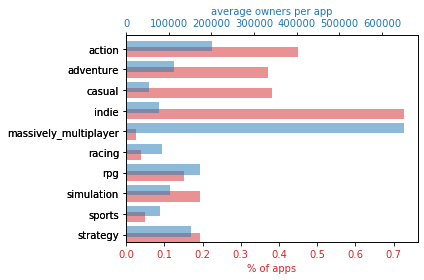

Index(['action', 'adventure', 'casual', 'indie', 'massively_multiplayer',
       'rpg', 'racing', 'simulation', 'sports', 'strategy'],
      dtype='object')

In [17]:
# percentage of apps in each genre
genre_cols = df1.columns[-10:]

total_owners_per_genre = df1[genre_cols].multiply(df1['owners'], axis='index').sum()
average_owners_per_genre = total_owners_per_genre / df1[genre_cols].sum()

fig, ax1 = plt.subplots()

color = 'tab:red'
df1[genre_cols].mean().sort_index(ascending=False).plot.barh(ax=ax1, color=color, alpha=.5, position=.8)
# ax1.set_ylabel('genre')
ax1.set_xlabel('% of apps', color=color)
ax1.tick_params(axis='x', labelcolor=color)

ax2 = ax1.twiny()

color = 'tab:blue'
average_owners_per_genre.sort_index(ascending=False).plot.barh(ax=ax2, color=color, alpha=.5, position=.2, label='1')
ax2.set_xlabel('average owners per app', color=color)
ax2.tick_params(axis='x', labelcolor=color)

plt.tight_layout()
plt.show()

Distribution graphs (histogram/bar graph) of sampled columns:

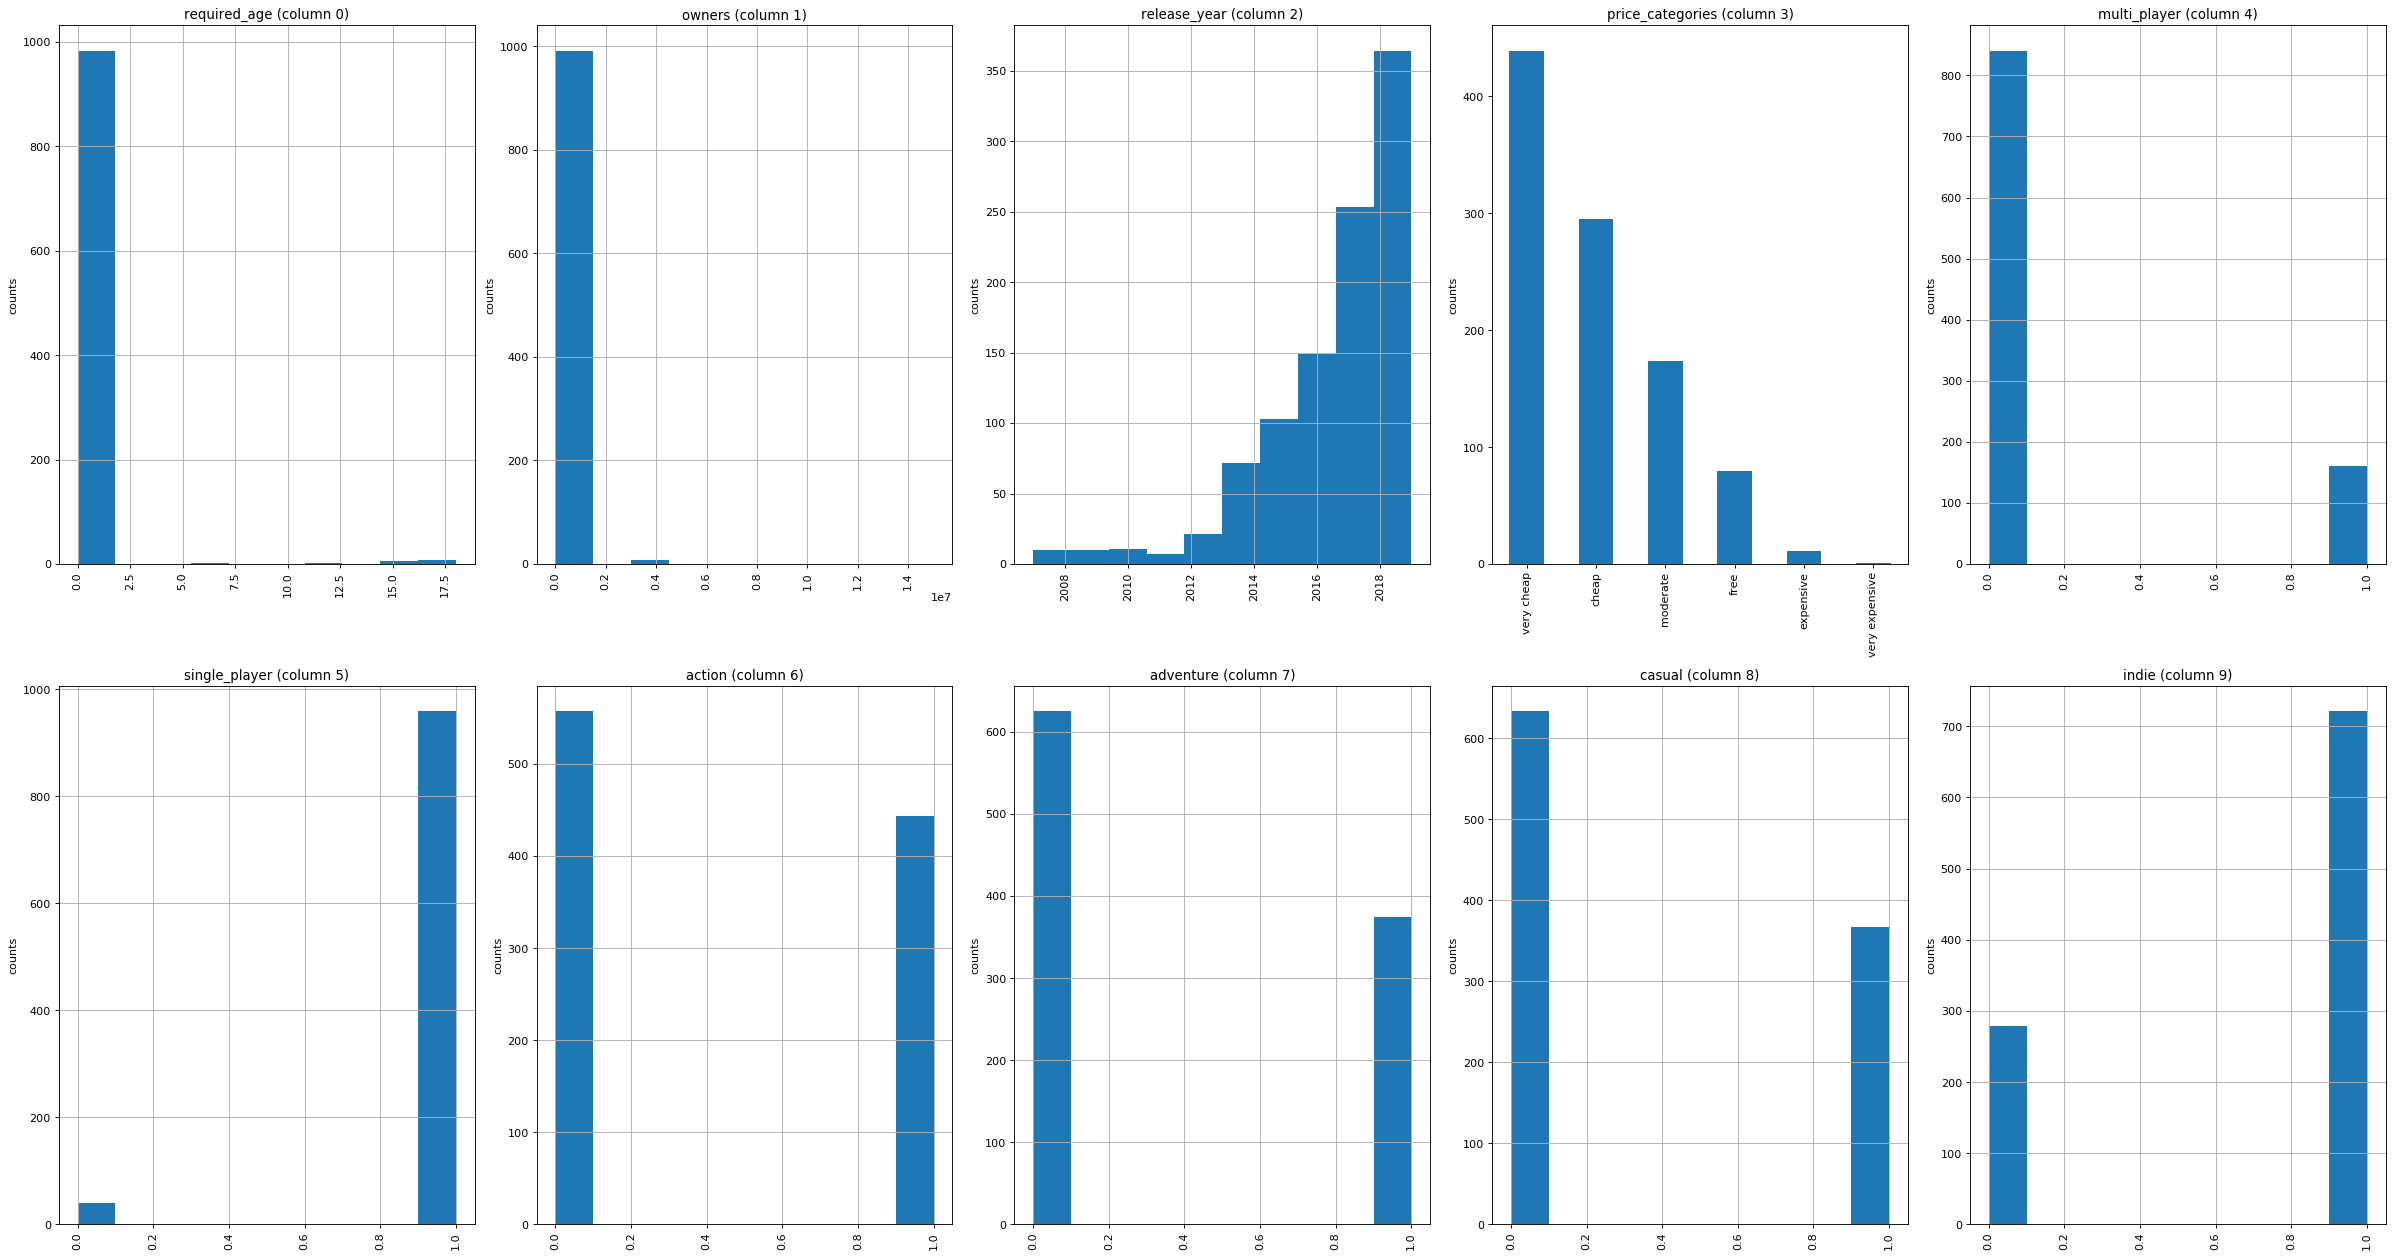

In [11]:
dfsample = df1.sample(1000)
dfsample.dataframeName = 'steam'
plotPerColumnDistribution(dfsample, 10, 5)

Correlation matrix:

Scatter and density plots:

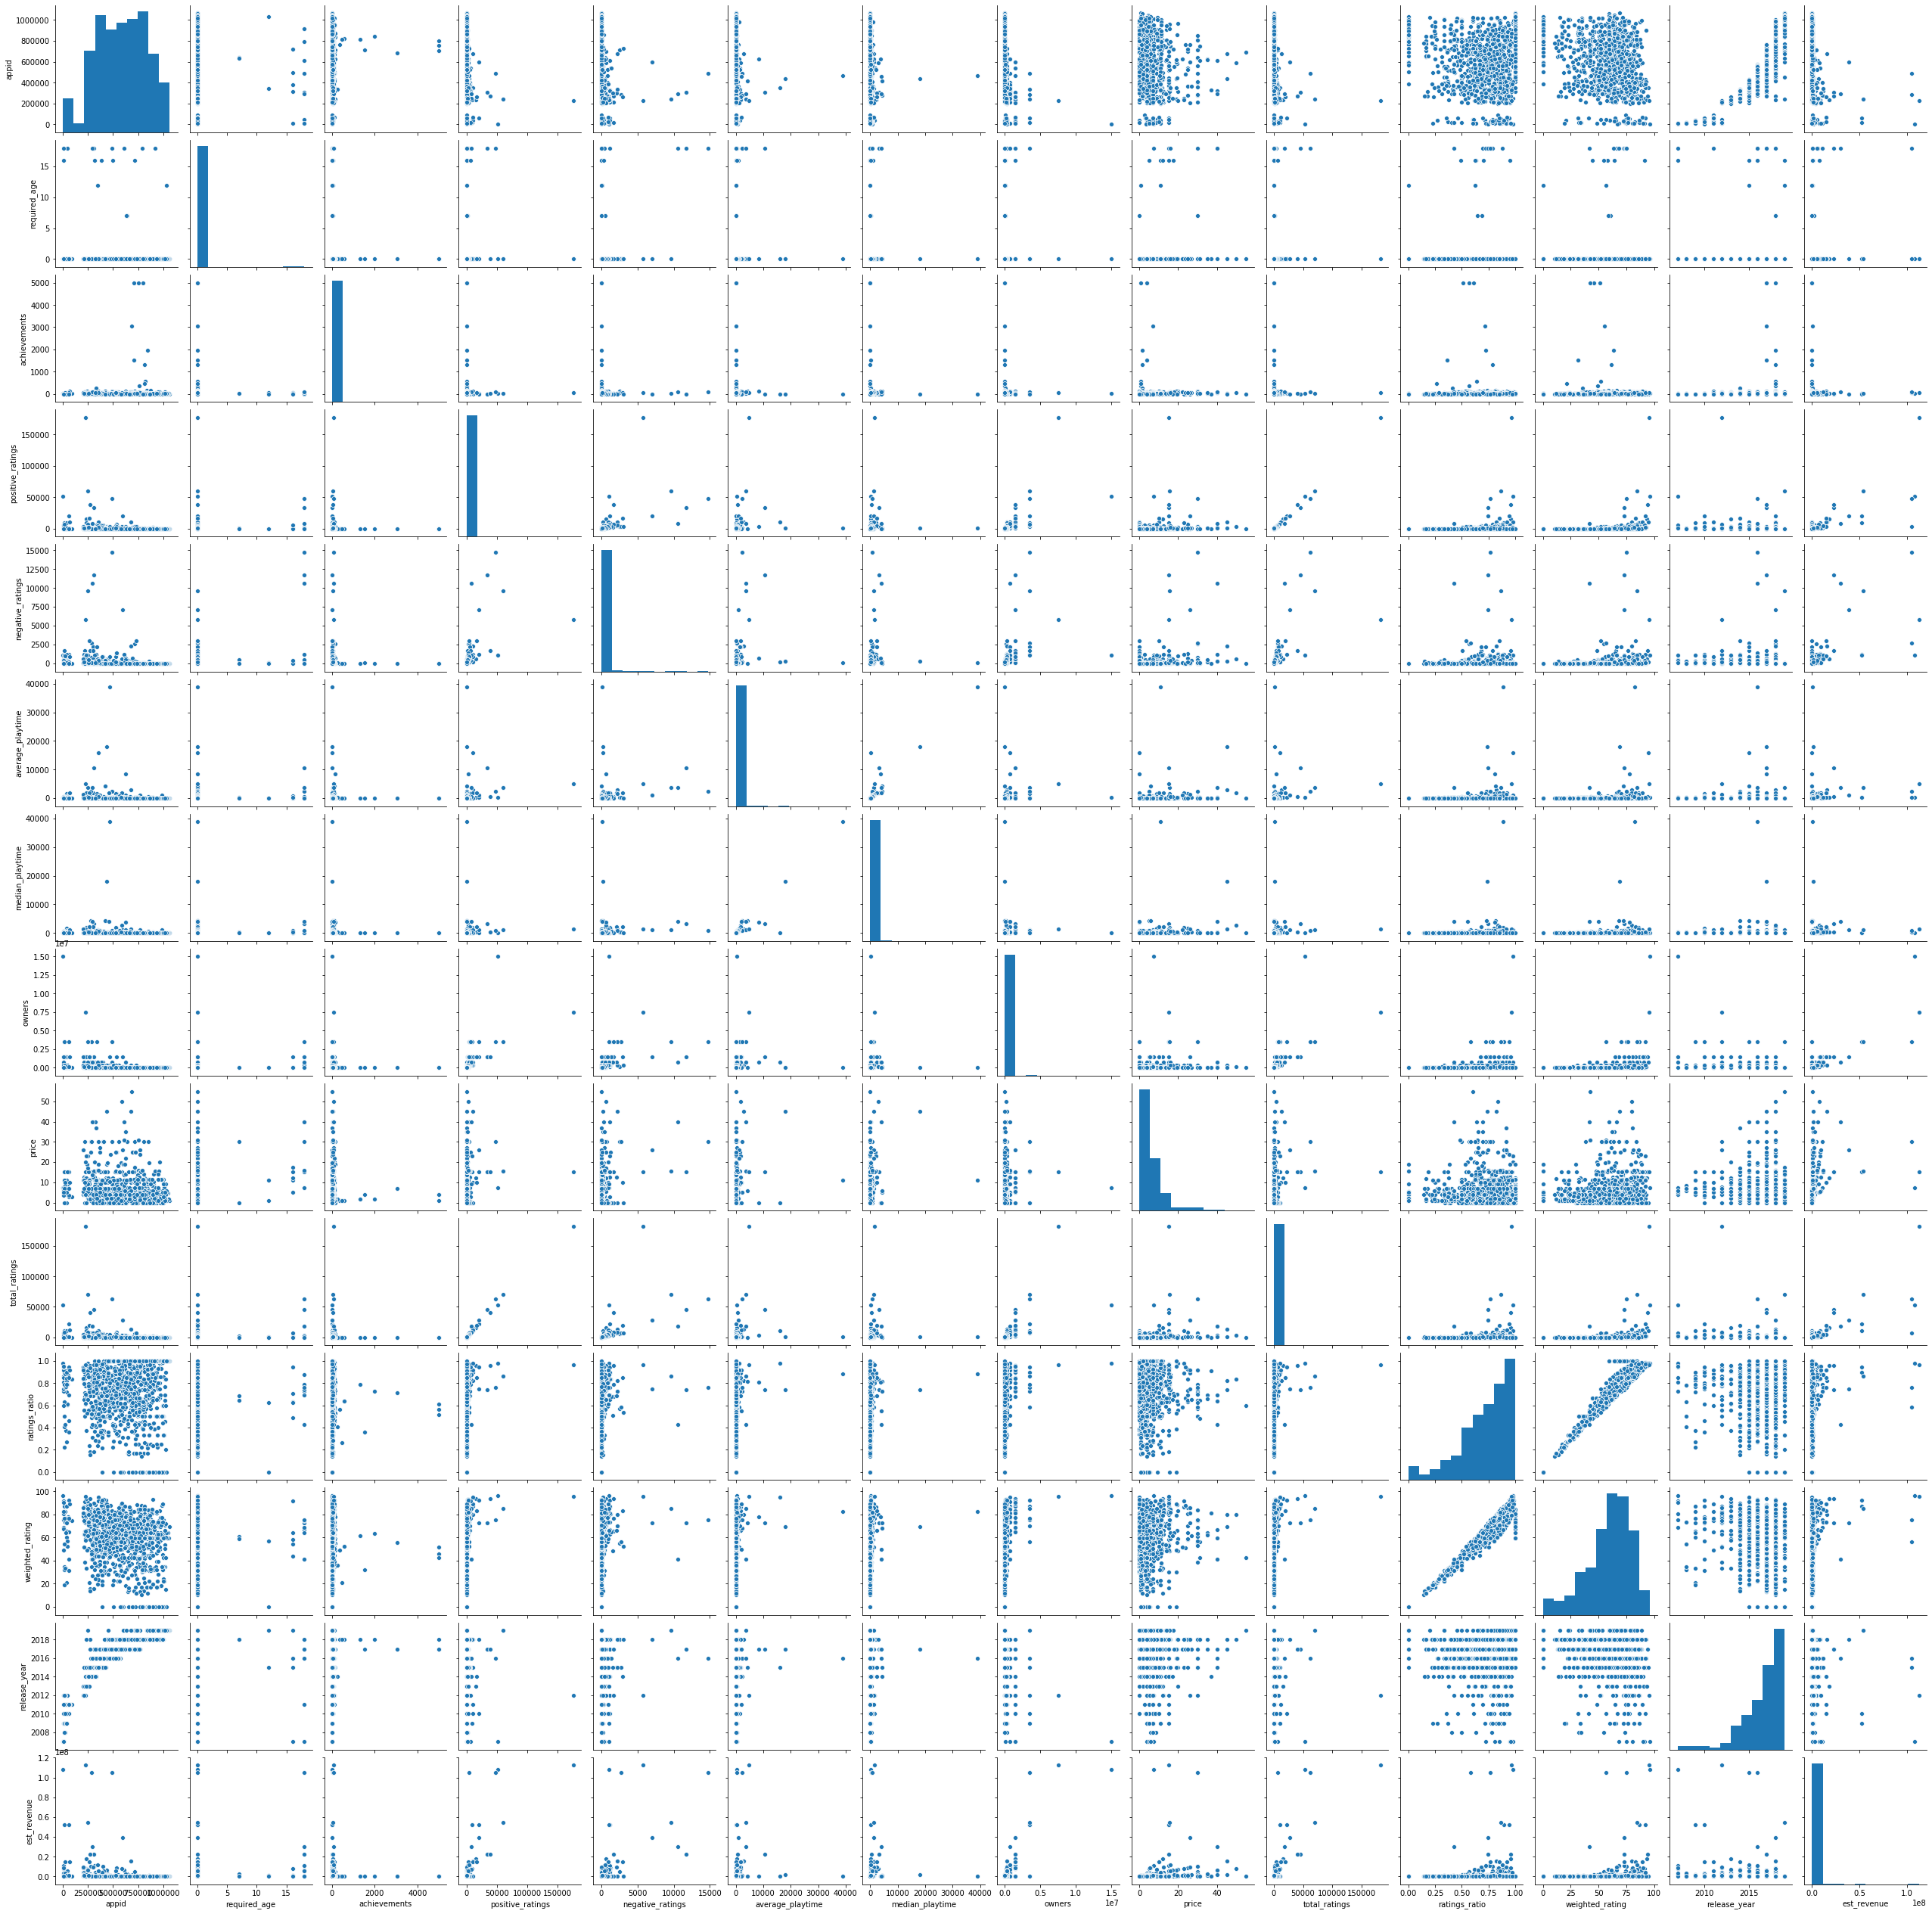

In [24]:
sns.pairplot(dfsample[dfsample.columns[:-12]])

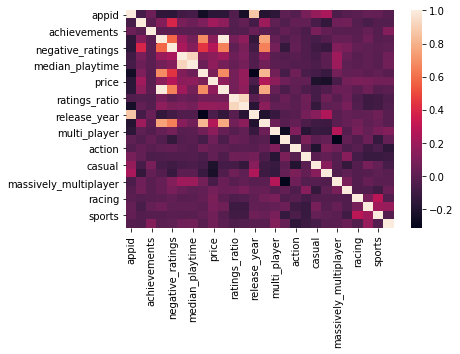

In [23]:
dfsample_corr = dfsample.corr()
sns.heatmap(dfsample_corr, square=False)

In [32]:
dfsample.to_csv('new_steam.csv')

In [47]:
features = ['ratings_ratio', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'price', 'est_revenue']

xf = dfsample.loc[:,features].values

yf = dfsample.loc[:, ['price_categories']]

xf = StandardScaler().fit_transform(xf)

xf

array([[ 5.84699533e-01,  9.69184286e-02,  1.17975059e-01, ...,
        -9.27670782e-02,  5.68485030e-01,  4.29125450e-02],
       [-6.31084039e-01, -1.22924601e-01, -1.64935912e-01, ...,
         7.64833320e-02, -3.15207087e-01, -1.45575258e-01],
       [ 1.02736800e+00, -7.88960924e-02, -1.64935912e-01, ...,
        -1.13477044e-01, -9.02862345e-01, -1.50731342e-01],
       ...,
       [ 1.07254699e+00, -1.05702565e-01, -1.75589464e-01, ...,
        -1.13477044e-01, -3.15207087e-01, -1.45575258e-01],
       [ 2.23276109e-01, -1.23972899e-01, -1.76773191e-01, ...,
        -1.13477044e-01, -9.02862345e-01, -1.50731342e-01],
       [-8.55913066e-02, -7.33550896e-02, -3.97732578e-04, ...,
        -7.06288389e-02,  2.77771532e+00, -3.77045647e-02]])

In [48]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(xf)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [49]:
principalDf['category'] = yf

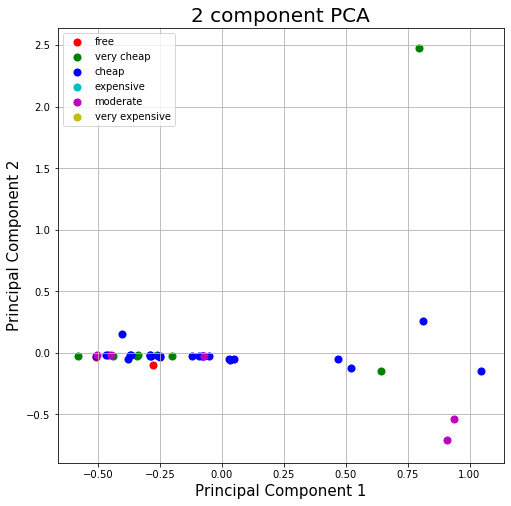

In [50]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['free', 'very cheap', 'cheap', 'expensive', 'moderate', 'very expensive']
colors = ['r', 'g', 'b', 'c', 'm', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['category'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## Conclusion
This concludes your starter analysis! To go forward from here, click the blue "Edit Notebook" button at the top of the kernel. This will create a copy of the code and environment for you to edit. Delete, modify, and add code as you please. Happy Kaggling!